# 4D Fast Accurate Fourier Transform - 64 points
## Ini from Axes-0

In [1]:
import numpy as np
import ctypes
from ctypes import *

import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math

import time


In [2]:
%matplotlib inline    


## Loading FFT routines

In [4]:
gridDIM = 64

size = gridDIM**4

axes0 = 0
axes1 = 1
axes2 = 2
axes3 = 3

makeC2C = 0
makeR2C = 1
makeC2R = 1

axesSplit_0 = 0
axesSplit_1 = 1
axesSplit_2 = 2
axesSplit_3 = 3

segment_axes0 = 0
segment_axes1 = 0
segment_axes2 = 0
segment_axes3 = 0


DIR_BASE = "/home/robert/Documents/new1/FFT/code/"

# FAFT
_faft128_4D = ctypes.cdll.LoadLibrary( DIR_BASE+'FAFT128_4D_R2C.so' )
_faft128_4D.FAFT128_4D_R2C.restype = int
_faft128_4D.FAFT128_4D_R2C.argtypes = [ctypes.c_void_p, ctypes.c_void_p, 
                                         ctypes.c_float, ctypes.c_float, ctypes.c_int, 
                                         ctypes.c_int, ctypes.c_int, ctypes.c_int]

cuda_faft = _faft128_4D.FAFT128_4D_R2C

# Inv FAFT
_ifaft128_4D = ctypes.cdll.LoadLibrary(DIR_BASE+'IFAFT128_4D_C2R.so')
_ifaft128_4D.IFAFT128_4D_C2R.restype = int
_ifaft128_4D.IFAFT128_4D_C2R.argtypes = [ctypes.c_void_p, ctypes.c_void_p, 
                                           ctypes.c_float, ctypes.c_float, ctypes.c_int, 
                                           ctypes.c_int, ctypes.c_int, ctypes.c_int]

cuda_ifaft = _ifaft128_4D.IFAFT128_4D_C2R

## Initializing Data

## Gaussian

In [5]:
def Gaussian(x,mu,sigma):
    return np.exp( - (x-mu)**2/sigma**2/2.  )/(sigma*np.sqrt( 2*np.pi  ))

def fftGaussian(p,mu,sigma):
    return np.exp(-1j*mu*p)*np.exp( - p**2*sigma**2/2.  )

 Amplitude x =  5.0
 Amplitude p =  6.0
        
mu_x =  1.5
mu_y =  1.5
mu_z =  1.5
mu_u =  1.5
sigma_x =  1.0
sigma_y =  1.0
sigma_z =  1.0
sigma_u =  1.0
   
n     =  64
dx    =  0.15625
dp    =  0.1875
           standard fft dp =  0.628318530718      
    
delta =  0.0046627424734
    
The Gaussian extends to the numerical error in single precision:
    min =  5.07874657504e-39


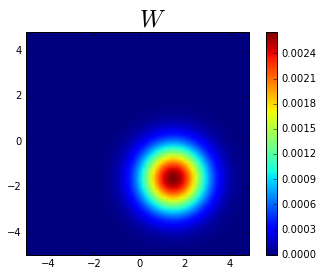

In [6]:
# Gaussian parameters
mu_x = 1.5
sigma_x = 1.

mu_y = 1.5
sigma_y = 1.

mu_z = 1.5
sigma_z = 1.

mu_u = 1.5
sigma_u = 1.

# Grid parameters
x_amplitude = 5.
p_amplitude = 6.                # With the traditional method p amplitude is fixed to: 2 * np.pi /( 2*x_amplitude ) 

dx = 2*x_amplitude/float(gridDIM)  # This is dx in Bailey's paper
dp = 2*p_amplitude/float(gridDIM)  # This is gamma in Bailey's paper

delta = dx*dp/(2*np.pi)

x_range = np.linspace( -x_amplitude, x_amplitude-dx, gridDIM) 
p = np.linspace( -p_amplitude, p_amplitude-dp, gridDIM) 

x = x_range[ np.newaxis, np.newaxis, np.newaxis, : ] 
y = x_range[ np.newaxis, np.newaxis, :, np.newaxis ] 
z = x_range[ np.newaxis, :, np.newaxis, np.newaxis ] 
u = x_range[ :, np.newaxis, np.newaxis, np.newaxis ]

f =  Gaussian(x,mu_x,sigma_x)*Gaussian(y,mu_y,sigma_y)*Gaussian(z,mu_z,sigma_z)*Gaussian(u,mu_u,sigma_u)

plt.imshow( f[:, :, 32, 32], extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )

axis_font = {'size':'24'}
plt.text( 0., 5.1, '$W$' , **axis_font)
plt.colorbar()

#plt.ylim(0,0.44)


print ' Amplitude x = ',x_amplitude
print ' Amplitude p = ',p_amplitude
print '        '

print 'mu_x = ', mu_x
print 'mu_y = ', mu_y
print 'mu_z = ', mu_z
print 'mu_u = ', mu_u
print 'sigma_x = ', sigma_x
print 'sigma_y = ', sigma_y
print 'sigma_z = ', sigma_z
print 'sigma_u = ', sigma_u
print '   '

print 'n     = ', x.size
print 'dx    = ', dx
print 'dp    = ', dp
print '           standard fft dp = ',2 * np.pi /( 2*x_amplitude ) , '     '
print '    '
print 'delta = ', delta


print '    '

print 'The Gaussian extends to the numerical error in single precision:'  
print '    min = ', np.min(f)

## $W$ TRANSFORM FROM AXES-0

### After the transfom, f_gpu[:, :, :32, :] contains real values and f_gpu[:, :, 32:, :] contains imaginary values. f33_gpu contains the 33th. complex values  

In [7]:
# Matrix for the 33th. complex values

f33 = np.zeros( [64, 64 ,1, 64], dtype = np.complex64 )

In [8]:
# Copy to GPU

f_gpu = gpuarray.to_gpu( np.ascontiguousarray( f , dtype = np.float32 ) )
f33_gpu = gpuarray.to_gpu( np.ascontiguousarray( f33 , dtype = np.complex64 ) )

print '         GPU memory Total       ', pycuda.driver.mem_get_info()[1]/float(2**30) , 'GB'
print '         GPU memory Free        ', pycuda.driver.mem_get_info()[0]/float(2**30) , 'GB'

         GPU memory Total        0.499267578125 GB
         GPU memory Free         0.209053754807 GB


In [9]:
f_gpu.shape

(64, 64, 64, 64)

### Forward Transform

In [10]:
# Executing FFT
t_init = time.time() 

cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes0, axes0, makeR2C, axesSplit_0 )
#cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes1, axes1, makeC2C, axesSplit_0 )
#cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes2, axes2, makeC2C, axesSplit_0 )
#cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes3, axes3, makeC2C, axesSplit_0 )

t_end = time.time() 

print 'computation time = ', t_end - t_init

computation time =  6.51343202591


In [11]:
cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes1, axes1, makeC2C, axesSplit_0 )

1

In [12]:
cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes2, axes2, makeC2C, axesSplit_0 )

1

In [13]:
cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes3, axes3, makeC2C, axesSplit_0 )

1

### Real Parts

In [14]:
# Getting the real-value data from f_gpu and joining to the f33_gpu real-value data 

f_real = np.append( f_gpu[:,:,:32,:].get(), f33_gpu.get().real, axis = 2 )

(-6.0, 6.0)

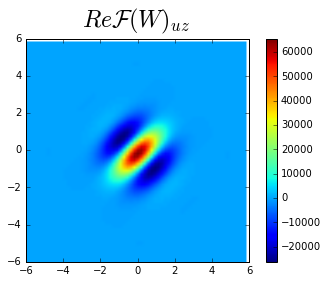

In [15]:
plt.imshow( f_real[:,:,32,32]/float(np.sqrt(size))  ,
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-p_amplitude/2. , 1.1*p_amplitude, '$Re \\mathcal{F}(W)_{uz}$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude)
plt.ylim(-p_amplitude , p_amplitude)

(-6.0, 6.0)

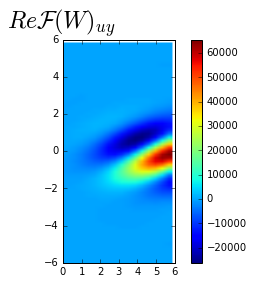

In [28]:
plt.imshow( f_real[:,32,:,32]/float(np.sqrt(size))  ,
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-p_amplitude/2. , 1.1*p_amplitude, '$Re \\mathcal{F}(W)_{uy}$',  **axis_font )

plt.xlim( 0 , p_amplitude )
plt.ylim(-p_amplitude , p_amplitude)

(-6.0, 6.0)

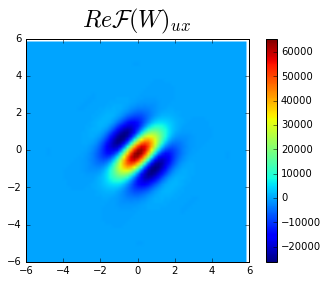

In [17]:
plt.imshow( f_real[:,32,32,:]/float(np.sqrt(size))  ,
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-p_amplitude/2. , 1.1*p_amplitude, '$Re \\mathcal{F}(W)_{ux}$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude)
plt.ylim(-p_amplitude , p_amplitude)

(-6.0, 6.0)

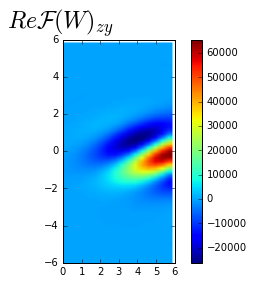

In [29]:
plt.imshow( f_real[32,:,:,32]/float(np.sqrt(size))  ,
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-p_amplitude/2. , 1.1*p_amplitude, '$Re \\mathcal{F}(W)_{zy}$',  **axis_font )

plt.xlim( 0, p_amplitude)
plt.ylim(-p_amplitude , p_amplitude)

(-6.0, 6.0)

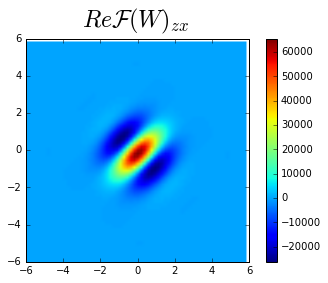

In [19]:
plt.imshow( f_real[32,:,32,:]/float(np.sqrt(size))  ,
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-p_amplitude/2. , 1.1*p_amplitude, '$Re \\mathcal{F}(W)_{zx}$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude)
plt.ylim(-p_amplitude , p_amplitude)

(-6.0, 0)

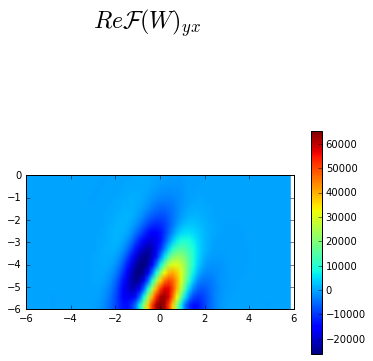

In [30]:
plt.imshow( f_real[32,32,:,:]/float(np.sqrt(size))  ,
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-p_amplitude/2. , 1.1*p_amplitude, '$Re \\mathcal{F}(W)_{yx}$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude)
plt.ylim(-p_amplitude , 0 )

### Imaginary Parts

In [21]:
# Getting the imag-value data from f_gpu and joining to the f33_gpu imag-value data 

f_imag = np.append( f_gpu[:,:,32:,:].get(), f33_gpu.get().imag, axis = 2 )

(-6.0, 6.0)

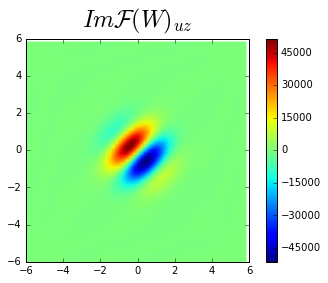

In [22]:
plt.imshow( f_imag[:,:,32,32]/float(np.sqrt(size))  ,
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-p_amplitude/2. , 1.1*p_amplitude, '$Im \\mathcal{F}(W)_{uz}$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude)
plt.ylim(-p_amplitude , p_amplitude)

(-6.0, 6.0)

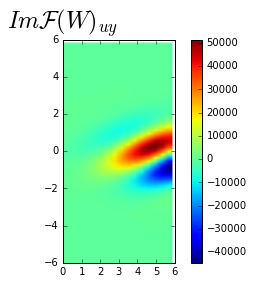

In [31]:
plt.imshow( f_imag[:,32,:,32]/float(np.sqrt(size))  ,
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-p_amplitude/2. , 1.1*p_amplitude, '$Im \\mathcal{F}(W)_{uy}$',  **axis_font )

plt.xlim( 0 , p_amplitude)
plt.ylim(-p_amplitude , p_amplitude)

(-6.0, 6.0)

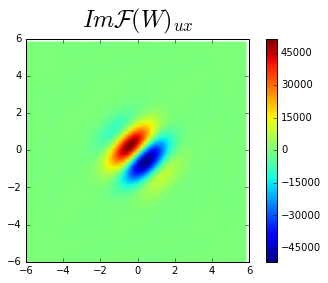

In [24]:
plt.imshow( f_imag[:,32,32,:]/float(np.sqrt(size))  ,
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-p_amplitude/2. , 1.1*p_amplitude, '$Im \\mathcal{F}(W)_{ux}$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude)
plt.ylim(-p_amplitude , p_amplitude)

(-6.0, 6.0)

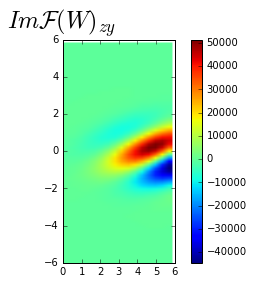

In [32]:
plt.imshow( f_imag[32,:,:,32]/float(np.sqrt(size))  ,
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-p_amplitude/2. , 1.1*p_amplitude, '$Im \\mathcal{F}(W)_{zy}$',  **axis_font )

plt.xlim( 0 , p_amplitude)
plt.ylim(-p_amplitude , p_amplitude)

(-6.0, 6.0)

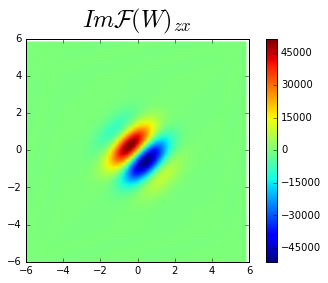

In [26]:
plt.imshow( f_imag[32,:,32,:]/float(np.sqrt(size))  ,
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-p_amplitude/2. , 1.1*p_amplitude, '$Im \\mathcal{F}(W)_{zx}$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude)
plt.ylim(-p_amplitude , p_amplitude)

(-6.0, 0)

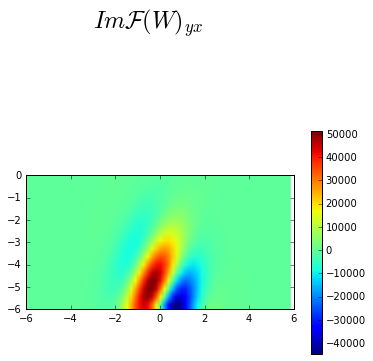

In [33]:
plt.imshow( f_imag[32,32,:,:]/float(np.sqrt(size))  ,
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-p_amplitude/2. , 1.1*p_amplitude, '$Im \\mathcal{F}(W)_{yx}$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude)
plt.ylim(-p_amplitude , 0 )

### Inverse Transform

In [34]:
# Executing iFFT
t_init = time.time() 

cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes3, axes3, makeC2C, axesSplit_0 )
#cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes2, axes2, makeC2C, axesSplit_0 )
#cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes1, axes1, makeC2C, axesSplit_0 )
#cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes0, axes0, makeC2R, axesSplit_0 )

t_end = time.time() 

print 'computation time = ', t_end - t_init

computation time =  4.08784079552


In [35]:
cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes2, axes2, makeC2C, axesSplit_0 )

1

In [36]:
cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes1, axes1, makeC2C, axesSplit_0 )

1

In [37]:
cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes0, axes0, makeC2R, axesSplit_0 )

1

(-5.0, 4.84375)

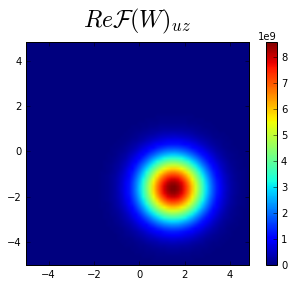

In [49]:
plt.imshow( f_gpu[:,:,32,32].get()/float(size)  ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-x_amplitude/2. , 1.1*x_amplitude, '$Re \\mathcal{F}(W)_{uz}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude - dx )
plt.ylim(-x_amplitude , x_amplitude - dx )

(-5.0, 4.84375)

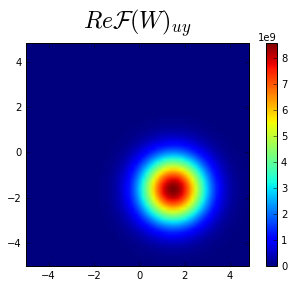

In [48]:
plt.imshow( f_gpu[:,32,:,32].get()/float(size)  ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-x_amplitude/2. , 1.1*x_amplitude, '$Re \\mathcal{F}(W)_{uy}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude - dx )
plt.ylim(-x_amplitude , x_amplitude - dx )

(-5.0, 4.84375)

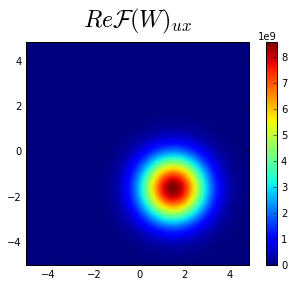

In [47]:
plt.imshow( f_gpu[:,32,32,:].get()/float(size)  ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-x_amplitude/2. , 1.1*x_amplitude, '$Re \\mathcal{F}(W)_{ux}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude - dx )
plt.ylim(-x_amplitude , x_amplitude - dx )

(-5.0, 4.84375)

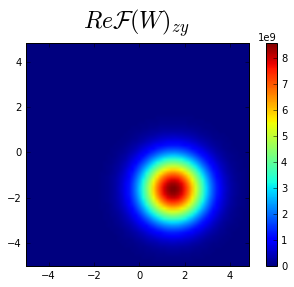

In [46]:
plt.imshow( f_gpu[32,:,:,32].get()/float(size)  ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-x_amplitude/2. , 1.1*x_amplitude, '$Re \\mathcal{F}(W)_{zy}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude - dx )
plt.ylim(-x_amplitude , x_amplitude - dx )

(-5.0, 5.0)

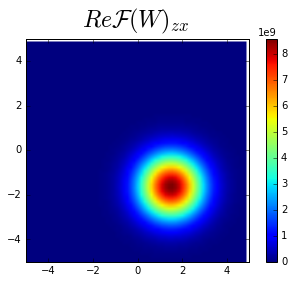

In [42]:
plt.imshow( f_gpu[32,:,32,:].get()/float(size)  ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-x_amplitude/2. , 1.1*x_amplitude, '$Re \\mathcal{F}(W)_{zx}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude - dx )
plt.ylim(-x_amplitude , x_amplitude - dx )

(-5.0, 4.84375)

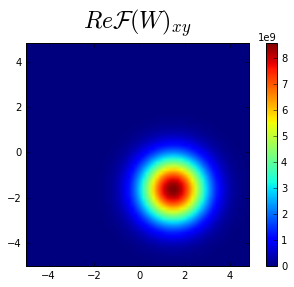

In [45]:
plt.imshow( f_gpu[32,32,:,:].get()/float(size)  ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-x_amplitude/2. , 1.1*x_amplitude, '$Re \\mathcal{F}(W)_{xy}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude - dx )
plt.ylim(-x_amplitude , x_amplitude - dx )